In [163]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
import random
from math import log, sin, pi
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D

## CNN for DNA sequences

In [160]:
fname="DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter = ",",
                    usecols=(0,1), unpack=True, dtype=str)

N_dna=len(sy) #number of samples
Ls=len(sx[0]) #length of each string

perc_train=0.8
N_train_dna=int(N*perc_train)
N_test_dna=N-N_train_dna

#one-hot encoding to associate each character to a sequence of 0 and 1
Q = ["A","C","G","T"]
Nc=4
onehc={Q[i]:i for i in range(Nc)} #one-hot encoding
print(onehc)

y_dna = sy.astype(int) #data conversion 
L_dna = Ls*Nc #length of input layer
x_dna = np.zeros((N_dna,L_dna)) #every row is an input

for n in range(N_dna): #for each sample
    for i in range(Ls): #for each character
        x_dna[n][i*4 + onehc[sx[n][i]]] = 1
        
x_dna = x_dna.reshape((x_dna.shape[0],int(x_dna.shape[1]/4),4,1))

#split tain/test-validation
(x_train_dna,y_train_dna) = (x_dna[:N_train_dna],y_dna[:N_train_dna]) #TRAINING SET
(x_test_dna,y_test_dna)  = (x_dna[N_train_dna:],y_dna[N_train_dna:]) #TEST SET

print("Fraction of data=1 in the training:",y_train_dna.sum()/N_train_dna)
print("Fraction of data=1 in the test:",y_test_dna.sum()/N_test_dna)

{'A': 0, 'C': 1, 'G': 2, 'T': 3}
Fraction of data=1 in the training: 0.24333333333333335
Fraction of data=1 in the test: 0.25833333333333336


In [164]:
from keras import regularizers, initializers
from keras.optimizers import SGD 

reg = regularizers.l1(0.0001) #lasso, with 0.1 doesn't converge
#ini = initializers.RandomNormal(mean=0,stddev=0.5) #initialization of the weigths
opt1 = SGD(learning_rate=0.1,
           momentum=0.9,
           nesterov=True) 


def compile_model_dna(optimizer=opt1,activation="relu",dropout_rate=0, x_f = 4,n_f = 5):
    
    # create the mode
    model = Sequential()
    
    model.add(Conv2D(filters=n_f,kernel_size=(6,4), 
                 activation="relu",
                 input_shape=(16,4,1),
                 kernel_regularizer=reg
                 #kernel_initializer=ini
                 ))
    #model.add(AveragePooling2D((2,1))) #first and only pooling; from 5 numbers to 1

    #model.add(Conv2D(filters=25, kernel_size=(4,1), activation="relu"))
    model.add(Flatten())
    model.add(Dense(x_f*L,activation=activation)) 
    model.add(Dense(L/2,activation=activation))
    model.add(Dense(L/4,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid"))
    
    # compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [165]:
def fit_and_plot(model = compile_model_dna(), x_train = x_train_dna, y_train = y_train_dna, x_test = x_test_dna, y_test = y_test_dna, epochs = 50, batch_size =20):
    
    fit = model.fit(x_train, y_train, 
               epochs=epochs, batch_size=batch_size,
               validation_data=(x_test,y_test),
                shuffle=True)
    #Plot the results

    score = model.evaluate(x_test, y_test, verbose=1)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # look into training history

    # summarize history for accuracy
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # summarize history for loss
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

After a grid search similar to the one of the previous exercise we obtained the following parameters

Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 0.5548 - accuracy: 0.7362 - val_loss: 0.4480 - val_accuracy: 0.7833
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.2816 - accuracy: 0.8856 - val_loss: 0.1287 - val_accuracy: 0.9633
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.1078 - accuracy: 0.9754 - val_loss: 0.0459 - val_accuracy: 0.9967
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0822 - accuracy: 0.9829 - val_loss: 0.0764 - val_accuracy: 0.9833
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0833 - accuracy: 0.9882 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0260 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 

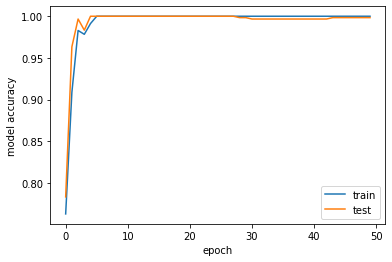

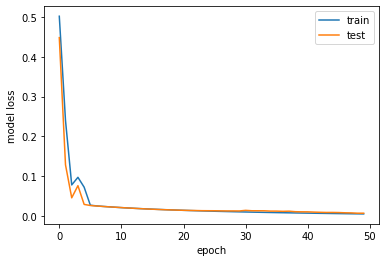

In [166]:
fit_and_plot(model = compile_model_dna(dropout_rate=0, x_f = 12,n_f = 75), epochs = 50, batch_size =20)

### Confusion matrix for DNA sequences' network

In [223]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.set_printoptions(precision=2, suppress=True)

counts_dna = [len(y_test_dna)-np.sum(y_test_dna, axis=0),np.sum(y_test_dna, axis=0)]
print("Labels and frequencies in test set: ", counts_dna)
model_dna = compile_model_dna(dropout_rate=0, x_f = 12,n_f = 75)
model_dna.fit(x_train_dna, y_train_dna, 
               epochs=50, batch_size=20,
               validation_data=(x_test_dna,y_test_dna),
                shuffle=True, verbose=0)

predict_dna = (model_dna.predict(x_test_dna)).round()

confusion_dna = confusion_matrix(y_test_dna, predict_dna)/counts_dna

Labels and frequencies in test set:  [445, 155]


Text(76.2, 0.5, 'predicted label')

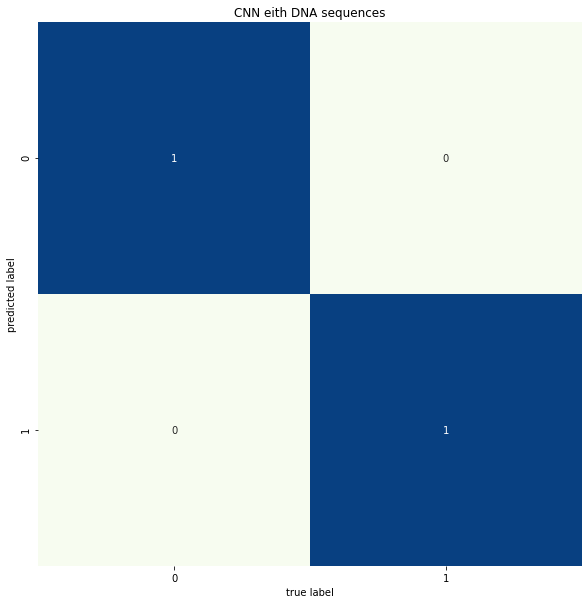

In [225]:
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1 = sns.heatmap(confusion_dna, square=True, annot=True, cbar=False, cmap='GnBu', xticklabels=[0,1], yticklabels=[0,1], ax=ax1)
ax1.set_title('CNN eith DNA sequences')
ax1.set_xlabel('true label')
ax1.set_ylabel('predicted label')

As expected when we saw the accuracy of the model converginf to one, the confusion matrix is the identity. It means that thanks to convolutional architecture and pooling the CNN classifies correctly all the sequences recognizing the presence of the "key".

## Convolutional neural network

In [3]:
random.seed(12345)

step = lambda DX, bias: round((log(random.random()) * DX) * 2*(random.randint(0,1)-0.5) + bias)
def pattern(y,z,a,i):
    """...."""
    return round((3-2*y) * a * sin((pi*i)/z))

random.seed(12345)
#pattern features
Z = 12
A = 500

#data
N = 10000
L = 60

DX = 50
bias = 5

y = [0] * N # a zeros array and we don't want here to use numpy 
x = [[0] * L for i in range(N)]

# generating the x samples 


for n in range(N):
    if n > 0 : 
        x[n][0] = x[n-1][-1]
    for j in range(1,L):
        x[n][j] = x[n][j-1] + step(DX,bias)

    y[n] = n%3
    if y[n] > 0:
        j0 = random.randint(0,L-1-Z)
        for j in range(Z):
            x[n][j0+j] += pattern(y[n],Z,A,j)

In [4]:
x = np.array(x)
N = len(x)
print(N)

# these categories are going to the matrix useful for categorical cross entropy
categ = np.array(y)
N_categ = 3 # essendo il numero di colonne dell'array delle categorie 
y = np.zeros((N,N_categ))

mask = np.array([[n,categ[n]] for n in range(len(categ))])
y[mask[:,0],mask[:,1]] = 1
print(y[0],'\n',y[1],'\n',y[2])

perc_train = 0.8
N_train = int(N * perc_train)
N_val = N - N_train

xm = np.mean(x, axis=1).reshape(N,-1)
x = x - xm

std = np.std(x, axis=1).reshape(N,-1)
x = x / std

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

10000
[1. 0. 0.] 
 [0. 1. 0.] 
 [0. 0. 1.]


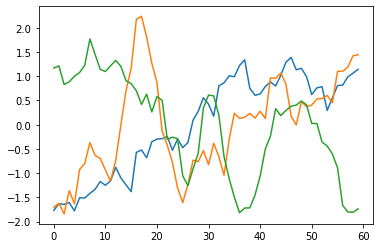

In [5]:
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

## Data reshaping

In [6]:
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

## Convolutional NN

In [7]:
from keras import initializers, regularizers
reg = regularizers.l1(0.01) # for the lambda in lasso regularization
np.random.seed(12345)
# it draws from a normal distribution
ini = initializers.RandomNormal(mean=0, stddev= 0.05)

model = Sequential()
model.add(Conv1D(filters=5, kernel_size=11,
          kernel_regularizer = reg,
          kernel_initializer = ini,
          activation = "relu",
          input_shape = input_shape
          ))

model.add(AveragePooling1D(5))
model.add(Conv1D(filters=5, kernel_size=7, activation="relu"))
model.add(Flatten())
model.add(Dense(10,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(N_categ, activation="softmax"))

print(model.summary())

from keras import optimizers
opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [8]:
batch_size = 250
epochs = 250

fit = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=2, shuffle=True)

0.6883 - val_loss: 0.7636 - val_accuracy: 0.7050
Epoch 53/250
32/32 - 0s - loss: 0.7666 - accuracy: 0.6876 - val_loss: 0.7285 - val_accuracy: 0.7105
Epoch 54/250
32/32 - 0s - loss: 0.7780 - accuracy: 0.6862 - val_loss: 0.7320 - val_accuracy: 0.7105
Epoch 55/250
32/32 - 0s - loss: 0.7653 - accuracy: 0.6989 - val_loss: 0.7358 - val_accuracy: 0.7070
Epoch 56/250
32/32 - 0s - loss: 0.7680 - accuracy: 0.6917 - val_loss: 0.7414 - val_accuracy: 0.7075
Epoch 57/250
32/32 - 0s - loss: 0.7563 - accuracy: 0.6975 - val_loss: 0.7341 - val_accuracy: 0.7090
Epoch 58/250
32/32 - 0s - loss: 0.7606 - accuracy: 0.6963 - val_loss: 0.7541 - val_accuracy: 0.7020
Epoch 59/250
32/32 - 0s - loss: 0.7576 - accuracy: 0.6999 - val_loss: 0.7246 - val_accuracy: 0.7135
Epoch 60/250
32/32 - 0s - loss: 0.7529 - accuracy: 0.6948 - val_loss: 0.7239 - val_accuracy: 0.7165
Epoch 61/250
32/32 - 0s - loss: 0.7631 - accuracy: 0.6969 - val_loss: 0.7213 - val_accuracy: 0.7215
Epoch 62/250
32/32 - 0s - loss: 0.7579 - accuracy: 

63/63 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.7655

Test loss: 0.6551474928855896
Test accuracy: 0.765500009059906


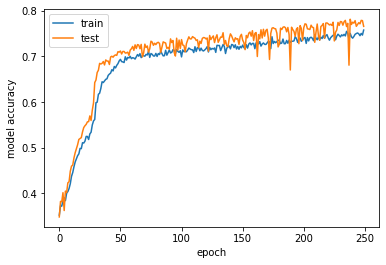

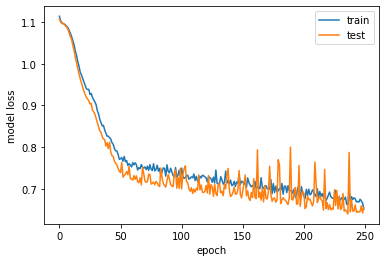

In [9]:
#Plot the results

score = model.evaluate(x_val, y_val, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# look into training history

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Visualizing the confusion matrix

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

# per la confusion matrix è necessario contare quante volte le labels compaiono all'interno dei nostri dati. Vista la scelta di usare delle labels non unidimensionali ma array di dimensione pari al numero di categorie per ogni sample posso fare: 
# per contare quante volte un sample è stato classificato nella prima categoria prendo la prima colonna dell'array y_val e scrivo np.sum(y_val[0]), in questo modo essendo y_val[0] un array di zero e uno quelle volte in cui il sample appartiene alla prima categoria allora comparirà un "uno" altrimenti uno zero. Sommando gli elementi dell'array conto dunque quanti samples rientrano nella prima categoria. Lo steso discorso per le altre due.

counts = np.sum(y_val, axis=0)
print("Labels and frequencies in test set: ", counts)

confusion_nn = confusion_matrix(y_val.argmax(axis=1), model.predict(x_val).argmax(axis=1))/counts[:,None]
# counts[:,None] altro non è che un modo per scrivere l'array dei conteggi con una dimensione in più. Esso infatti nasce come array unidimensionale mentre lo vorremmo trasporre quindi tante righe e una colonna per poter usare il broadcasting e dividere la confusion matrix per counts. Il procedimento è identico ad usare np.newaxis che è effettivamente un None

labels = ["absent","negative","positive"] # sono le tre categorie 

Labels and frequencies in test set:  [667. 666. 667.]


In [11]:
y_val.argmax(axis=1) #argmax mi restituisce la colonna dove la probabilità che il sample appartenga a quella determinata categoria è maggiore. 
# la stessa cosa vale, in termini di probabilità per y_predict essendo le labels scritte in one hot encoding a noi interessa la label predetta con la migliore probabilità tra le tre: quindi con argmaz selezioniamo innanzitutto il massimo oer ogni riga delle probabilità e con arg il numero della colonna che è la categoria 

array([2, 0, 1, ..., 1, 2, 0], dtype=int64)

Text(76.2, 0.5, 'predicted label')

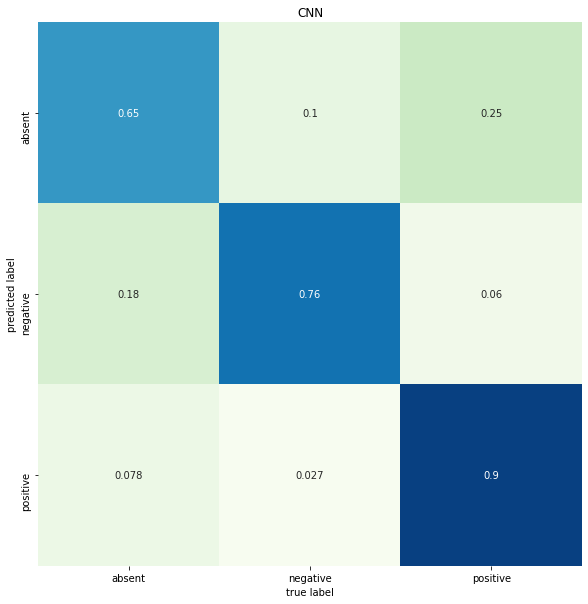

In [226]:
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1 = sns.heatmap(confusion_nn, square=True, annot=True, cbar=False, cmap='GnBu', xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_title('CNN')
ax1.set_xlabel('true label')
ax1.set_ylabel('predicted label')

## Changing the signal to noise ratio

The scope of this part is, changing the amplitude of the signal, watching how the network varies its training on the samples. Decreasing the amplitude A makes more difficult for the network to understand the pattern inside the signal.

In [53]:
#A = 50
random.seed(12345)
# generating the x samples 

def traj(x,y,A,N=10000,L=60,DX=50,bias=5,Z=12):
    for n in range(N):
        if n > 0 :
            x[n][0] = x[n-1][-1]
        for j in range(1,L):
            x[n][j] = x[n][j-1] + step(DX,bias)
        y[n] = n%3
        if y[n] > 0:
            j0 = random.randint(0,L-1-Z)
            for j in range(Z):
                x[n][j0+j] += pattern(y[n],Z,A,j)
    #categ1 = np.array(y1)
    categ1 = y
    N_categ = 3 # essendo il numero di colonne dell'array delle categorie 
    y2 = np.zeros((N,N_categ))

    mask1 = np.array([[n,categ1[n]] for n in range(len(categ1))]).astype(int)
    y2[mask1[:,0],mask1[:,1]] = 1
    #print('These are the labels encoded in a categorical way to use multiclass classification and cross entropy loss','\n',y2[0],'\n',y2[1],'\n',y2[2])

    perc_train = 0.8
    N_train = int(N * perc_train)
    N_val = N - N_train

    xm = np.mean(x1, axis=1).reshape(N,-1)
    x = x - xm

    std = np.std(x1, axis=1).reshape(N,-1)
    x = x / std
    return x,y2

In [14]:
type(y1)
# necessariamente y1 inizialmente deve essere una lista quando creo l'array categ, questo infatti è ottenuto castando y1 della precedente cella ad array e se già y1 fosse un array allora riscontreremmo problemi avendo poi una logical mask fatta di array nested. Se invece parto con y1 come array e non casto categ1 ad array allora ho risolto il problema.

numpy.ndarray

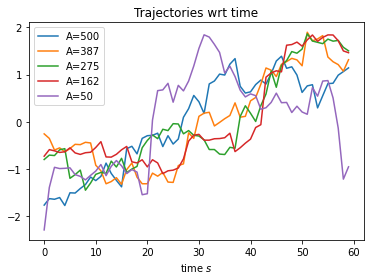

In [32]:
y1 = np.zeros(N)
x1 = np.zeros((N,L))
for n in np.linspace(500,50,5):
    plt.plot(traj(x1,y1,n)[0][0], label="A=%i" %n)
plt.title('Trajectories wrt time')
plt.xlabel('time $s$')
plt.legend()

In this way i represent the different trajectories created with various values of the amplitude A. In particular we see the firs trajectory $x_{0}$ for each amplitude. 

What is the value of A i would expect the network starts to fail recognizing the categories of bumps in trajectories?



In [33]:
def preprocessing(x,y,A,perc_train = 0.8,L=60):
    # da mettere dentro l'altra funzione delle traiettorie 
    N_train = int(N * perc_train)
    N_val = N - N_train
    # using the function whose results are the trajectories and the labels
    x1 = traj(x,y,A)[0]
    y2 = traj(x,y,A)[1]

    # dividing samples into training and test set  
    x_train1 = x1[:N_train]
    y_train1 = y2[:N_train]
    x_val1 = x1[N_train:]
    y_val1 = y2[N_train:]

    # reshaping the data to fit the model
    x_train1 = x_train1.reshape(x_train1.shape[0],L,1)
    x_val1 = x_val1.reshape(x_val1.shape[0],L,1)
    return x_train1,y_train1,x_val1,y_val1

In [34]:
def compile_model():
    reg = regularizers.l1(0.01) # for the lambda in lasso regularization
    np.random.seed(12345)
    # it draws from a normal distribution
    ini = initializers.RandomNormal(mean=0, stddev= 0.05)

    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=11,
            kernel_regularizer = reg,
            kernel_initializer = ini,
            activation = "relu",
            input_shape = input_shape
            ))

    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(N_categ, activation="softmax"))

    opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    return model 

In [57]:
# definisco una lista di score ottenuti a partire dai fit con diversi A
score_A_train_test = []

y1 = np.zeros(N)
x1 = np.zeros((N,L))
A_list = [500. , 387.5, 275. , 162.5,  50. ]

# computing a sort of gridsearch for the amplitude values
for n in A_list:
    x_train1,y_train1,x_val1,y_val1 = preprocessing(x1,y1,n,perc_train = 0.8,L=60)

    fit_A = compile_model().fit(x_train1, y_train1, batch_size=batch_size, epochs=50, validation_data=(x_val1,y_val1), verbose=0, shuffle=True)
    # così poche epochs perchè a noi interessa vedere dove inizia a FALLIRE il modello quindi già all'inizio la loss potrebbe essere molto elevata per quei casi in cui il modello non riesce a riconoscere le traiettorie sinusoidali
    score_A_train_test.append((fit_A.history['accuracy'][-1],fit_A.history['val_accuracy'][-1])) # gli ultimi valori all'epoch 50 di accuratezza sul training e sul test set 


In [147]:
score_A_train_test

[(0.625, 0.6399999856948853),
 (0.4645000100135803, 0.4754999876022339),
 (0.3970000147819519, 0.4025000035762787),
 (0.3238750100135803, 0.3334999978542328),
 (0.3251250088214874, 0.3334999978542328)]

In [68]:
# the worst A value is collected from the tuples of the previous cell. Each row correspond to the training and test accuracy on the network for a different A value

A_worst = A_list[np.argmin(score_A_train_test)//2]

In [118]:
def draw_normalized_confusion_matrix(x_set, y_set, keras_model, labels = ["absent","negative","positive"], verbose=False) :
    from sklearn.metrics import confusion_matrix
    import seaborn as sns 
    #np.set_printoptions(precision=2, suppress=True)

    counts = np.sum(y_set, axis=0)
    confusion_nn = confusion_matrix(y_set.argmax(axis=1), keras_model.predict(x_set).argmax(axis=1))/counts[:,None]

    if verbose :
        print("Labels and frequencies in test set:\n", labels, "\n", counts)
        print("text confusion matrix:\n",confusion_nn)

    fig, ax1 = plt.subplots(1,1, figsize=(10,10))
    ax1 = sns.heatmap(confusion_nn, square=True, annot=True, cbar=False, cmap='GnBu', xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('CNN Confusion Matrix')
    ax1.set_xlabel('true label')
    ax1.set_ylabel('predicted label')

In [121]:
# computing the fit explicitly for thew worst A value
y2 = np.zeros(N)
x2 = np.zeros((N,L))
x_train_cm,y_train_cm,x_val_cm,y_val_cm = preprocessing(x2,y2,A_worst,perc_train = 0.8,L=60)

model_cm = compile_model()

Labels and frequencies in test set:
 ['absent', 'negative', 'positive'] 
 [667. 666. 667.]
text confusion matrix:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


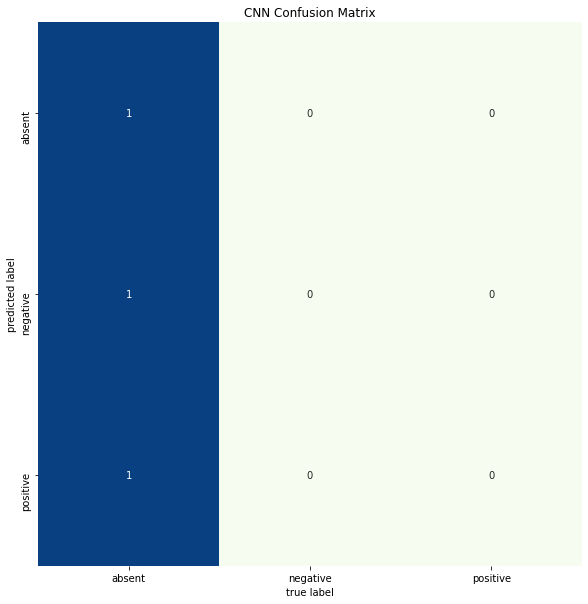

In [122]:
draw_normalized_confusion_matrix(x_val_cm, y_val_cm,model_cm, labels = ["absent","negative","positive"], verbose=True)

In [99]:
a = model.predict(x_val).argmax(axis=1)
b = y_val.argmax(axis=1)

In [116]:
a[(a == 0) & (a == b)].shape[0]/667

0.6461769115442278

In [117]:
a[(a == 1) & (a == b)].shape[0]/666

0.7552552552552553

In [127]:
c = model_cm.predict(x_val_cm).argmax(axis=1)
d = y_val_cm.argmax(axis=1)

In [130]:
c[(c == 0) & (c == d)].shape[0]/667

1.0

In [133]:
c[(c == 1) & (c == d)]

array([], dtype=int64)

### Considerations

After these calculations we verified the truth of the confusion matrix both for the initial model trained with $A=500$ and for the last one with $A=162.5$. We noticed that, running different times the confusion matrix with the new samples, the model manages to recognize only 1/3 of the data. Indeed accuracy is about $\approx 0.33$. Since the classification is characterized by 3 categories it means that the CNN has 1/3 probability to correctly classify the samples, therefore it corresponds to a kind of randomly weighted network with no power of classification.